# The MEC datasets
This tutorial provide statistics and access to the MEC datasets together with an example of in-memory indexing.

In [1]:
import pymongo
import numpy as np


db = pymongo.MongoClient()['mec']

def indexing(docs_collection):
    """
    In-memory indexing assuming that tags appear once in docs
    """
    size = db[docs_collection].count()
    inverted_index = {}
    docs = []
    for i, record in enumerate(db[docs_collection].find()):
        tags, probs = record['clarifai']['tag'], record['clarifai']['probs']
        docs.append(record['_id'])
        if record['clarifai']['tag'] is not None:
            for j, tag in enumerate(tags):
                try:
                    inverted_index[tag].append((i, probs[j]))
                except KeyError:
                    inverted_index[tag] = [(i, probs[j])]
    return inverted_index, docs, size



In [2]:
def tf(tag, doc, inverted_index):
    try:
        posting = dict(inverted_index[tag])
        x = 0.5 + 0.5 * posting[doc] / max(posting.values())
    except KeyError:
        x = 0.0
    return x

def idf(tag, inverted_index, size):
    try:
        n = len(inverted_index[tag])
        x = np.log(1 + ((size - n) / n))
    except KeyError:
        x = 0.0
    except ZeroDivisionError:
        x = 0.0
    return x

In [3]:
inverted_index, docs, size = indexing('calzedoniajson_items_0')

In [4]:
tag, doc = 'comfort', 0
print 'tf of', tag, 'in doc', doc, tf(tag, doc, inverted_index)
print 'idf of', tag, idf(tag, inverted_index, size)


tf of comfort in doc 0 0.879896591396
idf of comfort 4.7184988713


## Explore tags
In order to understand the dataset it is crucial to observe de distribution of idf, tf and their correlation.

In [5]:
idf_distribution = np.array([idf(x, inverted_index, size) for x 
                    in sorted(inverted_index.keys())])
avg_tf_distribution = []
for tag in sorted(inverted_index.keys()):
    m = np.mean([tf(tag, x[0], inverted_index) for x in inverted_index[tag]])
    avg_tf_distribution.append(m)
avg_tf_distribution = np.array(avg_tf_distribution)


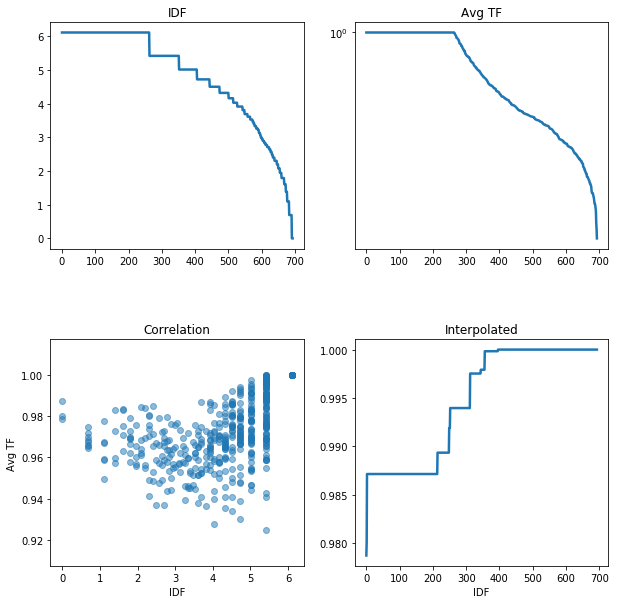

In [6]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
idf_y = sorted([x for x in idf_distribution], key=lambda x: -x)
tf_y = sorted([x for x in avg_tf_distribution], key=lambda x: -x)
coordinates = zip(idf_distribution, avg_tf_distribution)
coordinates = sorted(coordinates, key=lambda x: x[0])
i_y = []
for j in range(0, len(coordinates)):
    i_y.append(max([k[1] for k in coordinates[:j+1]]))

axes[0, 0].plot(idf_y, linewidth=2.5)
axes[0, 0].set_title('IDF')
axes[0, 1].plot(tf_y, linewidth=2.5)
axes[0, 1].set_yscale('log')
axes[0, 1].set_title('Avg TF')
axes[1, 0].scatter(idf_distribution, avg_tf_distribution, alpha=0.5)
axes[1, 0].set_title('Correlation')
axes[1, 0].set_xlabel('IDF')
axes[1, 0].set_ylabel('Avg TF')
axes[1, 1].plot(i_y, linewidth=2.5)
axes[1, 1].set_title('Interpolated')
axes[1, 1].set_xlabel('IDF')

fig.subplots_adjust(hspace=0.4)
plt.show()


## TF-IDF and Frequencies

In [7]:
def scores(inverted_index, docs):
    M = np.zeros(shape=(len(inverted_index), len(docs)))
    F = np.zeros(len(inverted_index))
    tags = sorted(inverted_index.keys())
    tag_count = sum([len(p) for p in inverted_index.values()])
    for i, tag in enumerate(tags):
        f = float(len(inverted_index[tag])) / tag_count
        F[i] = f
        for j, doc in enumerate(docs):
            tfidf = tf(tag, j, inverted_index) * idf(tag, inverted_index, size)
            M[i][j] = tfidf
    return M, F

In [8]:
tfidf, freq = scores(inverted_index, docs)
idf_map = sorted([x for x in enumerate(idf_distribution)], 
                 key=lambda x: -x[1])
freq_map = sorted([x for x in enumerate(freq)], 
                 key=lambda x: -x[1])

In [9]:
k = 10
tags = sorted(inverted_index.keys())
top_k_idf = [(tags[x[0]], x[1]) for x in idf_map[:k]]
top_k_freq = [(tags[x[0]], x[1]) for x in freq_map[:k]]

for i in range(0, k):
    print 'idf', top_k_idf[i][0], round(top_k_idf[i][1], 3), 'freq', top_k_freq[i][0], round(top_k_freq[i][1], 3)

idf Halloween 6.109 freq woman 0.04
idf Luna 6.109 freq fashion 0.034
idf World Wide Web 6.109 freq sexy 0.03
idf accident 6.109 freq girl 0.025
idf accomplishment 6.109 freq young 0.024
idf acoustic 6.109 freq pretty 0.023
idf acrobat 6.109 freq people 0.02
idf administration 6.109 freq glamour 0.019
idf advice 6.109 freq model 0.019
idf agility 6.109 freq adult 0.019


## Specificity across different datasets


In [10]:
calzedonia_i, calzedonia_d, calzedonia_s = indexing('calzedoniajson_items_0')
nowtv_i, nowtv_d, calzedonia_s = indexing('nowtvitjson_items_0')
calzedonia_tags = sorted(calzedonia_i.keys())
nowtv_tags = sorted(nowtv_i.keys())
calzedonia_tfidf, calzedonia_freq = scores(calzedonia_i, calzedonia_d)
nowtv_tfidf, nowtv_freq = scores(nowtv_i, nowtv_d)


In [11]:
def specificity(freq_a, tags_a, freq_b, tags_b):
    specs = []
    for i, tag in enumerate(tags_a):
        f = freq_a[i]
        try:
            fs = freq_b[tags_b.index(tag)]
            s = (f - fs) / np.sqrt(fs)
            specs.append(s)
        except ValueError:
            specs.append(f)
    return specs

In [12]:
calzedonia_specs = specificity(calzedonia_freq, 
                               calzedonia_tags,
                               nowtv_freq,
                               nowtv_tags
                              )
nowtv_specs = specificity(nowtv_freq, 
                               nowtv_tags,
                               calzedonia_freq,
                               calzedonia_tags
                              )

cs_map = sorted([x for x in enumerate(calzedonia_specs)], 
                 key=lambda x: -x[1])
ns_map = sorted([x for x in enumerate(nowtv_specs)], 
                 key=lambda x: -x[1])

s_map, s_tags = cs_map, calzedonia_tags
for pos, spec in s_map:
    print s_tags[pos], spec


woman 0.0404708520179
fashion 0.0338565022422
sexy 0.0295964125561
girl 0.025
young 0.0237668161435
pretty 0.022533632287
people 0.019730941704
glamour 0.0193946188341
model 0.0189461883408
adult 0.0187219730942
beautiful 0.0183856502242
elegant 0.0143497757848
portrait 0.0137892376682
wear 0.0136771300448
isolated 0.0133408071749
one 0.012668161435
summer 0.012668161435
thin 0.0113228699552
leisure 0.0108744394619
bikini 0.0104260089686
desktop 0.010201793722
water 0.00997757847534
cute 0.00908071748879
beach 0.00896860986547
lingerie 0.00874439461883
style 0.00863228699552
tan 0.00829596412556
relaxation 0.00818385650224
body 0.00795964125561
business 0.00795964125561
hair 0.00762331838565
vacation 0.00751121076233
recreation 0.00739910313901
erotic 0.0072869955157
health 0.00706278026906
travel 0.00706278026906
fun 0.0067264573991
person 0.00661434977578
no person 0.00639013452915
attractive 0.00616591928251
figure 0.00616591928251
sea 0.00594170403587
skin 0.00582959641256
fitness 

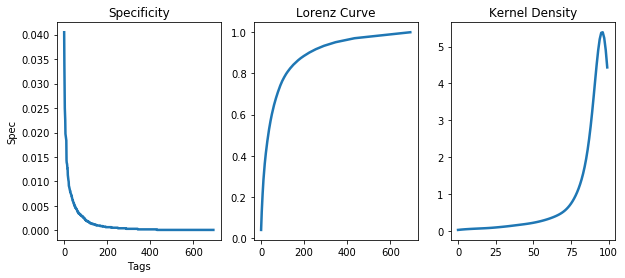

In [13]:
import matplotlib.pyplot as plt
import scipy.stats

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
S = np.array([x[1] for x in cs_map])
c, t = 0.0, S.sum()
lorenz = []
for v in S:
    c += np.abs(v)
    lorenz.append(c / t)
kde = scipy.stats.gaussian_kde(lorenz)
x = np.linspace(min(lorenz), max(lorenz), 100)
y = kde(x)
axes[0].plot(S, linewidth=2.5)
axes[0].set_title('Specificity')
axes[0].set_ylabel('Spec')
axes[0].set_xlabel('Tags')
axes[1].plot(lorenz, linewidth=2.5)
axes[1].set_title('Lorenz Curve')
axes[2].plot(y, linewidth=2.5)
axes[2].set_title('Kernel Density')

plt.show()

## Co-occurrences and mutual information
In order to measure the statistical relevance of tags co-occurrences, we need to compare the frequency of each observed co-occurrence with the expected probability.

As a first step, we estimate the probability of a tag as its relative frequency in the corpus.

In [14]:
def p_tag(tag, tags, freq):
    try:
        p = freq[tags.index(tag)]
    except ValueError:
        p = 0.0
    except KeyError:
        p = 0.0
    return p

As a second step, we observe the number of occurrences of each pair of tags used in the same documents.

In [15]:
bi_tag_index = {}
for doc in calzedonia_tfidf.T:
    tag_ids = [x[0] for x in enumerate(doc) if x[1] > 0]
    for i, tag in enumerate(tag_ids):
        for tag2 in tag_ids[i+1:]:
            try:
                bi_tag_index[(tag, tag2)] += 1
            except KeyError:
                bi_tag_index[(tag, tag2)] = 1.0


In [16]:
def p_bi_tag(a, b, tags, bi_tag_index):
    try:
        p = bi_tag_index[(tags.index(a), tags.index(b))] / sum(bi_tag_index.values())
    except ValueError:
        p = 0.0
    except KeyError:
        p = 0.0
    return p    

In [17]:
print p_bi_tag('beach', 'girl', calzedonia_tags, bi_tag_index)

0.000379495119693


In [18]:
def mi(t1, t2, tags, freq, bi_tags_index):
    p_b = p_bi_tag(t1, t2, tags, bi_tags_index)
    p1 = p_tag(t1, tags, freq)
    p2 = p_tag(t2, tags, freq)
    if p1 > 0 and p2 > 0:
        m = p_b * np.log(1 + p_b / p1*p2)
    else:
        m = 0
    return m
    

In [19]:
cooccurrences = []
for b in bi_tag_index.keys()[:1000]:
    t1, t2 = calzedonia_tags[b[0]], calzedonia_tags[b[1]]
    m = mi(t1, t2, calzedonia_tags, calzedonia_freq, bi_tag_index)
    cooccurrences.append((t1, t2, m))
for c in sorted(cooccurrences, key=lambda x: -x[2]):
    print c


(u'girl', u'model', 3.5680366943847684e-06)
(u'body', u'girl', 1.4639911288671535e-06)
(u'wear', u'young', 1.0003734882340057e-06)
(u'outdoors', u'people', 9.4639321738919927e-07)
(u'hair', u'portrait', 8.8139404480592298e-07)
(u'health', u'young', 8.4370336295774268e-07)
(u'erotic', u'lingerie', 8.0591201242663931e-07)
(u'health', u'pretty', 7.0596871779654144e-07)
(u'bikini', u'water', 6.9125596873340241e-07)
(u'brunette', u'pretty', 6.0770404449214549e-07)
(u'casual', u'elegant', 5.7770115673816227e-07)
(u'business', u'isolated', 4.7289397575891628e-07)
(u'leather', u'young', 4.2235200349667231e-07)
(u'fair weather', u'summer', 4.1625416175383613e-07)
(u'tan', u'water', 4.000435284351823e-07)
(u'two', u'wear', 3.9572623890012627e-07)
(u'lingerie', u'thin', 3.8655432338023165e-07)
(u'nature', u'young', 3.6608364646679276e-07)
(u'beach', u'tan', 3.4093544591154136e-07)
(u'desire', u'model', 3.241708967730759e-07)
(u'foot', u'people', 3.0710563475560844e-07)
(u'desktop', u'wear', 2.597